# Convert Translation LNM to Rotation LNM Model

In [1]:
from obspy import * 
from pandas import *
from os import listdir

import os
import netCDF4 as nc
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['workdir'] = data_path+"LNM/"

config['datadir_models'] = config['workdir']+"data/MODELS/"

config['datadir_data'] = config['workdir']+"data/"

config['datadir_final'] = config['workdir']+"data/FINAL/"

config['outdir_figures'] = root_path+"Documents/ROMY/LowNoiseModel/SRL/figures/300dpi/"

config['period_lower'] = 2.5
config['period_upper'] = 300

## Load Data

### Read Noise Models

load GSN models

In [4]:
df_gsn = read_csv(config['datadir_models']+"GSN_noise_model.csv", 
              dtype={'period': np.float32, 'minH': np.float32, 'minZ': 'float32'})

df_gsn.sort_values("period", inplace=True)

df_gsn['minH_acc'] = [10**(xx/20) for xx in df_gsn['minH']]
df_gsn['minZ_acc'] = [10**(xx/20) for xx in df_gsn['minZ']]

load NLNM from Petersen

In [5]:
tmp = np.load(config['datadir_models']+"noise_models.npz")

df_lnm = DataFrame()
df_lnm['periods'], df_lnm['nlnm'], df_lnm['nhnm'] = tmp['model_periods'], tmp['low_noise'], tmp['high_noise']; del tmp

df_lnm['nlnm_acc'] = [10**(xx/20) for xx in df_lnm['nlnm']]
df_lnm['nhnm_acc'] = [10**(xx/20) for xx in df_lnm['nhnm']]

### Load BFO Data

Kurrle & Widmer (2004)

In [6]:
df_bfo_vhz = read_csv(config['datadir_data']+"BFO_VHZ.csv", delimiter=" ",
                      dtype={'period': np.float32, 'minH': np.float32, 'minZ': 'float32'}, names=["f_mhz","db"])

df_bfo_vhz['periods'] = 1 / ( df_bfo_vhz.f_mhz * 1e-3 )
df_bfo_vhz['bhz'] = 10**(df_bfo_vhz.db/10)


df_bfo_vhe = read_csv(config['datadir_data']+"BFO_VHE.csv", delimiter=" ", 
                      dtype={'period': np.float32, 'minH': np.float32, 'minZ': 'float32'}, names=["f_mhz","db"])

df_bfo_vhe['periods'] = 1 / ( df_bfo_vhe.f_mhz * 1e-3 )
df_bfo_vhe['bhe'] = 10**(df_bfo_vhe.db/10)

### Read Velocity Models

In [7]:
rayleigh_model = "Rayleigh_Average/RAYLEIGH_vphase_land_only.pkl"
love_model = "Love_Average/LOVE_vphase_land_only.pkl"

vphase_rayl_median = read_pickle(config['workdir']+"data/PHASE_VELOCITY_MODEL/"+rayleigh_model)
vphase_love_median = read_pickle(config['workdir']+"data/PHASE_VELOCITY_MODEL/"+love_model)

### Load Velocity Confidence Interval

In [8]:
def __get_percentiles(arr):
    
    from numpy import zeros, nanpercentile, shape
    
    percentiles_lower = zeros(shape(arr)[1])
    percentiles_upper = zeros(shape(arr)[1])

    for kk in range(shape(arr)[1]):
        out = nanpercentile(arr[:, kk],  [5, 95])
        percentiles_upper[kk] = out[1]
        percentiles_lower[kk] = out[0]
        
    return percentiles_lower, percentiles_upper

In [9]:
df_vphase_rayl = read_pickle(config['datadir_final']+"vphase_land_rayleigh.pkl")

arr = df_vphase_rayl.iloc[:,1:].to_numpy().T

rayl_perc_lower, rayl_perc_upper = __get_percentiles(arr)

df_vphase_love = read_pickle(config['datadir_final']+"vphase_land_love.pkl")
arr = df_vphase_love.iloc[:,1:].to_numpy().T
love_perc_lower, love_perc_upper = __get_percentiles(arr)

## Interpolations

In [10]:
data = DataFrame()

data['periods'] = df_lnm['periods']

data['nlnm_acc'] = ( df_lnm['nlnm_acc'] )**2
data['nhnm_acc'] = ( df_lnm['nhnm_acc'] )**2

In [11]:
## phase velocities
data['vphase_rayl_median_interp'] = np.interp(data['periods'], vphase_rayl_median['periods_mod'], vphase_rayl_median['vphase_median'])
data['vphase_love_median_interp'] = np.interp(data['periods'], vphase_love_median['periods_mod'], vphase_love_median['vphase_median'])

## confidence interval Rayleigh
data['vphase_rayl_conf_upper'] = np.interp(data['periods'], df_vphase_rayl['period'], rayl_perc_upper)
data['vphase_rayl_conf_lower'] = np.interp(data['periods'], df_vphase_rayl['period'], rayl_perc_lower)

## confidence interval Love
data['vphase_love_conf_upper'] = np.interp(data['periods'], df_vphase_love['period'], love_perc_upper)
data['vphase_love_conf_lower'] = np.interp(data['periods'], df_vphase_love['period'], love_perc_lower)


data['gsn_minH_acc'] = ( np.interp(data['periods'], df_gsn['period'], df_gsn['minH_acc']) )**2
data['gsn_minZ_acc'] = ( np.interp(data['periods'], df_gsn['period'], df_gsn['minZ_acc']) )**2

## Rotation Models

In [12]:
data['rot_trans_lnm'] = ( np.sqrt( data['nlnm_acc'] ) / (data['vphase_rayl_median_interp']*1000) )**2
data['rot_trans_hnm'] = ( np.sqrt( data['nhnm_acc'] ) / (data['vphase_rayl_median_interp']*1000) )**2


data['rot_trans_gsn'] = ( np.sqrt( data['gsn_minZ_acc'] ) / (data['vphase_rayl_median_interp']*1000) )**2
data['rot_trans_gsn_conf_lower'] = ( np.sqrt( data['gsn_minZ_acc'] ) / (data['vphase_rayl_conf_upper']*1000) )**2
data['rot_trans_gsn_conf_upper'] = ( np.sqrt( data['gsn_minZ_acc'] ) / (data['vphase_rayl_conf_lower']*1000) )**2

data['rot_vert_gsn'] = ( -0.5* np.sqrt( data['gsn_minH_acc'] ) / (data['vphase_love_median_interp']*1000) )**2
data['rot_vert_gsn_conf_lower'] = ( -0.5* np.sqrt( data['gsn_minH_acc'] ) / (data['vphase_love_conf_upper']*1000) )**2
data['rot_vert_gsn_conf_upper'] = ( -0.5* np.sqrt( data['gsn_minH_acc'] ) / (data['vphase_love_conf_lower']*1000) )**2

modify dataframe

In [13]:
data.sort_values("periods", inplace=True)
data.reset_index(drop=True, inplace=True)

## Plotting

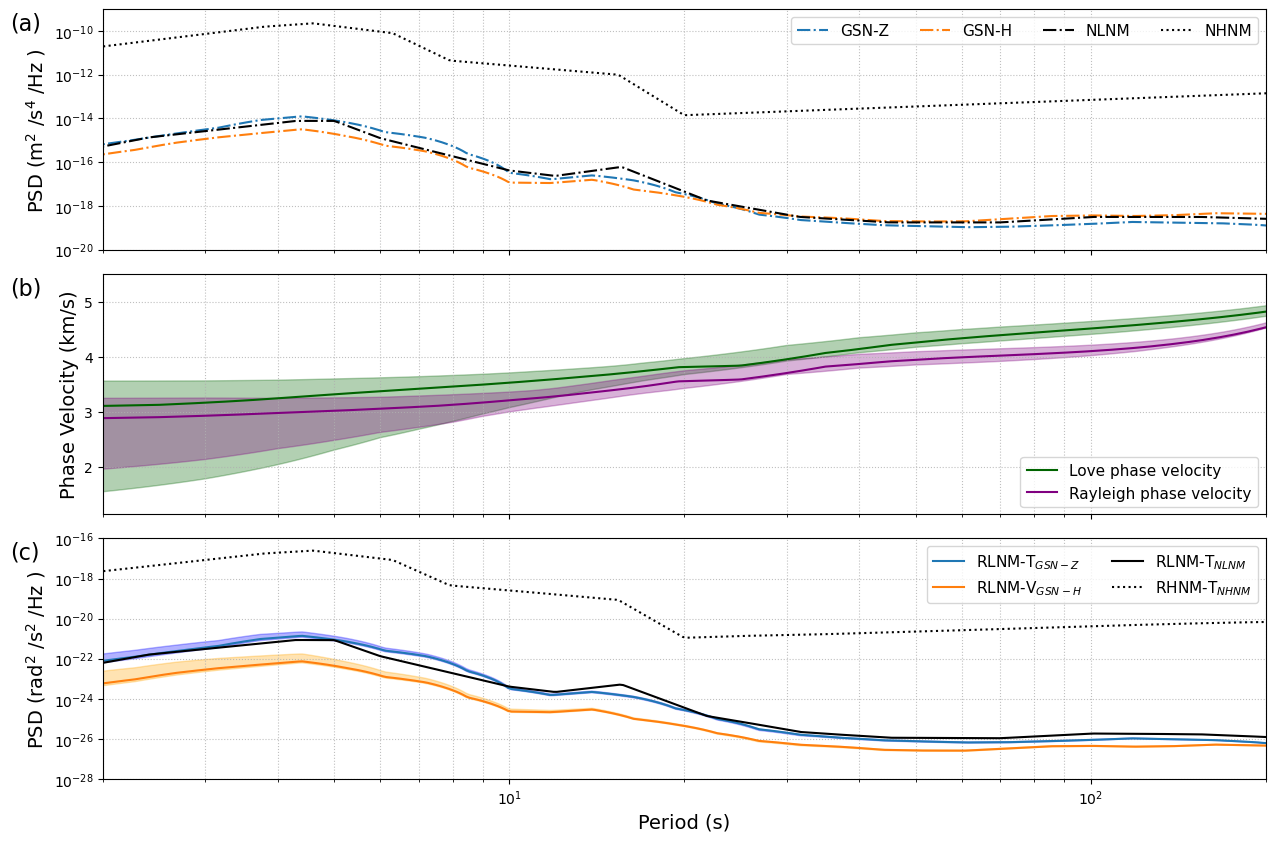

In [23]:
def __plot():

    N = 3
    font = 14

    plim = 580
    
    
    fig, ax = plt.subplots(N, 1, figsize=(15,10), sharex=True)

    plt.subplots_adjust(hspace=0.1)
    
    ## __________________________
    
    ax[0].loglog(data['periods'], data['gsn_minZ_acc'], ls="-.", label="GSN-Z")
    ax[0].loglog(data['periods'], data['gsn_minH_acc'], ls="-.", label="GSN-H")
    ax[0].loglog(data['periods'], data['nlnm_acc'], label="NLNM", ls="-.", color="black")
    ax[0].loglog(data['periods'], data['nhnm_acc'], label="NHNM", ls=":", color="black")
    

    ax[0].set_ylabel("PSD (m$^2$ /s$^4$ /Hz )", fontsize=font)
 
    ax[0].set_ylim(1e-20, 1e-9)
    
    ## __________________________
    
    ax[1].semilogx(data['periods'][:plim], data['vphase_love_median_interp'][:plim], label="Love phase velocity", color="darkgreen")
    ax[1].fill_between(data['periods'][:plim], data['vphase_love_conf_lower'][:plim], data['vphase_love_conf_upper'][:plim], color="darkgreen", alpha=0.3, zorder=0)

    ax[1].semilogx(data['periods'][:plim], data['vphase_rayl_median_interp'][:plim], label="Rayleigh phase velocity", color="purple")
    ax[1].fill_between(data['periods'][:plim], data['vphase_rayl_conf_lower'][:plim], data['vphase_rayl_conf_upper'][:plim], color="purple", alpha=0.3, zorder=0)

    
    ax[1].set_ylabel("Phase Velocity (km/s)", fontsize=font)
    
    ## __________________________
    
    ax[2].loglog(data['periods'][:plim], data['rot_trans_gsn'][:plim], label=r"RLNM-T$_{GSN-Z}$")
    ax[2].loglog(data['periods'][:plim], data['rot_vert_gsn'][:plim], label=r"RLNM-V$_{GSN-H}$")
    
    ax[2].loglog(data['periods'][:plim], data['rot_trans_lnm'][:plim], color="black", label="RLNM-T$_{NLNM}$")
    ax[2].loglog(data['periods'][:plim], data['rot_trans_hnm'][:plim], color="black", label="RHNM-T$_{NHNM}$", ls=":")
    
    ax[2].fill_between(data['periods'][:plim], data['rot_vert_gsn_conf_lower'][:plim], data['rot_vert_gsn_conf_upper'][:plim], color="orange", alpha=0.3)
    ax[2].fill_between(data['periods'][:plim], data['rot_trans_gsn_conf_lower'][:plim], data['rot_trans_gsn_conf_upper'][:plim], color="blue", alpha=0.3)

    
    
    ax[2].set_ylim(1e-28, 1e-16)

    ax[2].set_ylabel("PSD (rad$^2$ /s$^2$ /Hz )", fontsize=font)
    ax[2].set_xlabel("Period (s)", fontsize=font)
    
    for i in range(N):
        ax[i].grid(ls=":", zorder=-1, alpha=0.8, which="both")
        ax[i].tick_params(axis='x', labelsize=10)
        ax[i].tick_params(axis='y', labelsize=10)

    ax[0].text(.01, .99, '(a)', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .99, '(b)', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)
    ax[2].text(.01, .99, '(c)', ha='left', va='top', transform=ax[2].transAxes, fontsize=font+2)
    # ax[0].text(-.08, .99, '(a)', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
#     ax[1].text(-.08, .99, '(b)', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)
#     ax[2].text(-.08, .99, '(c)', ha='left', va='top', transform=ax[2].transAxes, fontsize=font+2)
        
    ax[0].legend(fontsize=font-3, loc=1, ncol=4)
    ax[1].legend(fontsize=font-3, loc=4)        
    ax[N-1].legend(fontsize=font-3, loc=1, ncol=2)
    
    ax[N-1].set_xlim(2, 2e2)
    
#     from matplotlib import ticker as mticker
#     ax[2].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs=[0.1,0.5]))
    
    plt.show();
    return fig

fig = __plot()

In [26]:
# fig.savefig(config['outdir_figures']+"TLNM_to_RLNM_withGSN.jpeg", format="jpeg", dpi=200, bbox_inches='tight')
fig.savefig(config['outdir_figures']+"figure4.pdf", format="pdf", dpi=200, bbox_inches='tight')

In [25]:
config['outdir_figures']

'/home/andbro/Documents/ROMY/LowNoiseModel/SRL/figures/300dpi/'

## Write Data to File

In [16]:
data_out = data.copy()

data_out['frequencies'] = 1/data_out['periods']
data_out.rename(columns={'rot_trans_lnm':'nlnm_rot_rate'}, inplace=True)
data_out.rename(columns={'rot_trans_hnm':'nhnm_rot_rate'}, inplace=True)


data_out

,periods,nlnm_acc,nhnm_acc,vphase_rayl_median_interp,vphase_love_median_interp,vphase_rayl_conf_upper,vphase_rayl_conf_lower,vphase_love_conf_upper,vphase_love_conf_lower,gsn_minH_acc,gsn_minZ_acc,nlnm_rot_rate,nhnm_rot_rate,rot_trans_gsn,rot_trans_gsn_conf_lower,rot_trans_gsn_conf_upper,rot_vert_gsn,rot_vert_gsn_conf_lower,rot_vert_gsn_conf_upper,frequencies
0,0.100000,1.584893e-17,7.079458e-10,2.604705,3.006500,3.251895,1.440197,3.695334,1.327554,1.202265e-16,8.511387e-17,2.336054e-24,1.043477e-16,1.254536e-23,8.048726e-24,4.103519e-23,3.325201e-24,2.201065e-24,1.705437e-23,10.000000
1,0.101391,1.597350e-17,6.912896e-10,2.604705,3.006500,3.251846,1.440501,3.695029,1.327554,1.193917e-16,8.291513e-17,2.354414e-24,1.018927e-16,1.222128e-23,7.841041e-24,3.995827e-23,3.302110e-24,2.186142e-24,1.693594e-23,9.862808
2,0.102802,1.609904e-17,6.750252e-10,2.604705,3.006500,3.251797,1.440809,3.694718,1.327554,1.185477e-16,8.071417e-17,2.372919e-24,9.949537e-17,1.189687e-23,7.633137e-24,3.888096e-23,3.278769e-24,2.171054e-24,1.681623e-23,9.727437
3,0.104232,1.622557e-17,6.591435e-10,2.604705,3.006500,3.251746,1.441121,3.694404,1.327554,1.176955e-16,7.851378e-17,2.391569e-24,9.715449e-17,1.157254e-23,7.425277e-24,3.780461e-23,3.255199e-24,2.155814e-24,1.669534e-23,9.593983
4,0.105682,1.634933e-17,6.436503e-10,2.604705,3.006500,3.251695,1.441438,3.694085,1.327554,1.168345e-16,7.631367e-17,2.409810e-24,9.487087e-17,1.124826e-23,7.217434e-24,3.672911e-23,3.231386e-24,2.140412e-24,1.657321e-23,9.462349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,94623.700000,3.715352e-11,1.183287e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,4.073809e-15,4.168691e-16,1.323394e-18,4.214822e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000011
997,95940.000000,3.974203e-11,1.236147e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,4.073809e-15,4.168691e-16,1.415596e-18,4.403106e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000010
998,97274.700000,4.251087e-11,1.291338e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,4.073809e-15,4.168691e-16,1.514221e-18,4.599697e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000010
999,98627.900000,4.547262e-11,1.349025e-05,5.298530,5.167375,5.331817,5.267753,5.243688,5.084252,4.073809e-15,4.168691e-16,1.619717e-18,4.805175e-13,1.484872e-23,1.466389e-23,1.502273e-23,3.814176e-23,3.703965e-23,3.939912e-23,0.000010


In [17]:
fname = "TLNM_to_RLNM.csv"

data_out.to_csv(config['datadir_final']+fname, sep=",")
print(f" -> writing to {config['datadir_final']}{fname}")

 -> writing to /home/andbro/kilauea-data/LNM/data/FINAL/TLNM_to_RLNM.csv


## Prepare Final Manuscript File

In [18]:
fname = "RLNM_manuscript.csv"

data_out2 = DataFrame()
data_out2['periods'] = data_out['periods']
data_out2['nlnm_rot_rate'] = data_out['nlnm_rot_rate']
data_out2['nhnm_rot_rate'] = data_out['nhnm_rot_rate']

data_out2[::5]

# data_out2.to_csv(config['datadir_final']+fname, sep=",")
data_out2.to_csv("~/Desktop/"+fname, sep=",")

print(f" -> writing to {config['datadir_final']}{fname}")

 -> writing to /home/andbro/kilauea-data/LNM/data/FINAL/RLNM_manuscript.csv
